# Source Code 1.1)

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline

### Load Data

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

print(f'train_x.shape : {train_x.shape}')
print(f'test_x.shape : {test_x.shape}')

170508288/170498071 [==============================] - 3s 0us/step
train_x.shape : (50000, 32, 32, 3)
test_x.shape : (10000, 32, 32, 3)


In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


### Data Preprocessing

In [4]:
train_x = (train_x - 127.5) / 127.5
test_x = (test_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


- -1 에서 1 사이의 값으로 정규화해주었습니다.

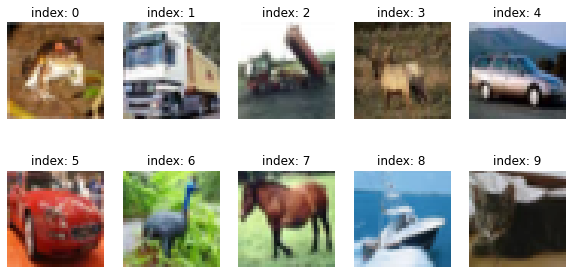

In [5]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i] + 1) / 2.0)
    plt.title(f'index: {i}')
    plt.axis('off')

plt.show()

- load image 10 개를 확인해보았습니다.

In [6]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

- data 를 shuffling 하고 batch 로 잘라 Dataset 으로 만들어주었습니다.

### Generator Modeling

In [7]:
def make_generator_model(momentum=0.8, alpha=0.2):

    model = tf.keras.Sequential()

    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Reshape((4, 4, 512)))

    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [8]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              819200    
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 256)         0

- 생성자 모델을 설계하였습니다.
- generator 로 모델을 생성해주었습니다.
- 모델의 Output 벡터 shape 이 입력 데이터 shape 인 (32, 32, 3) 으로 동일합니다.

generated_image.shape : (1, 32, 32, 3)


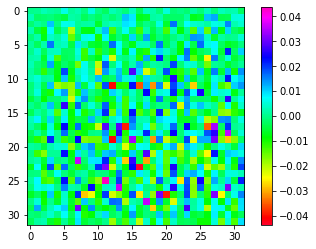

In [42]:
# Test
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(f'generated_image.shape : {generated_image.shape}')

plt.imshow(generated_image[0, :, :, 0], cmap='gist_rainbow')
plt.colorbar()
plt.show()

- (1, 100) 의 노이즈 벡터를 생성해 모델에 넣고 결과를 확인해보았습니다.
- generated_image 의 shape 도 (1, 32, 32, 3) 으로 올바르게 출력되었습니다.

### Discriminator Modeling

In [9]:
def make_discriminator_model(momentum=0.8, alpha=0.2):

    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.4))

    model.add(layers.Flatten())

    model.add(layers.Dense(1))

    return model

In [10]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)        

- 판별자 모델을 설계하였습니다.
- discriminator 로 모델을 생성해주었습니다.
- 모델의 Output 벡터는 **'각 이미지별 진짜라고 생각하는 정도값'** 입니다.

In [45]:
# Test
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00091099]], dtype=float32)>

- 앞서 생성한 노이즈 벡터를 판별자에 넣고 결과를 확인해보았습니다.

### Generator Loss

- Real Image 의 라벨 : 1
- Fake Image 의 라벨 : 0

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

- Generator 는 생성해내는 모든 이미지가 Real Image 의 라벨인 1 과 가까워야 합니다.
- 따라서, 생성해낸 이미지와 shape 이 같은 1 로 채워진 벡터와 비교합니다.

### Discriminator Loss

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

- Discriminator 는 Real Image 는 1 에 가깝게, Fake Image 는 0 에 가깝게 판별해내야 합니다.
- 따라서, Real Image 는 동일한 shape 의 1 로 채워진 벡터와 비교하여 loss 를 구하고
- Fake Image 는 동일한 shape 의 0 으로 채워진 벡터와 비교하여 loss 를 구합니다.
- 두 loss 를 더한 total_loss 를 줄여나가는 것이 목표입니다.

### Discriminator Accuracy

In [14]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

- Discriminator 가 Real Image 와 Fake Image 에 대해 얼마나 잘 판별하고 있는지에 대한 Accuracy 입니다.

### Optimizer

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

In [16]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### Train step Modeling

In [17]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output,
                                                              fake_output)
        
    grad_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(grad_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

- 배치 당 진행될 train step 을 정의해주었습니다.
- 한 배치사이즈의 노이즈 데이터를 생성
- 판별자로 각 데이터를 판별
- 판별된 값으로 loss 와 accuracy 계산
- 구해낸 loss 로 gradient 계산
- gradient 를 optimizer 에 입력해 가중치 갱신
- loss 와 accuracy 리턴

### Util Function

In [18]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        predictions[i]
        plt.imshow((predictions[i] + 1) / 2.0)
        plt.axis('off')
        
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                .format(os.getenv('HOME'), epoch, it))
    
    plt.show()

- 학습 현황을 확인할 수 있는 샘플 생성 함수입니다.

In [19]:
rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch):
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
    
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                .format(os.getenv('HOME'), epoch))
    
    plt.show()

- train_step 이 리턴하는 loss 와 accuracy 값을 시각화하는 함수입니다.

In [20]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Training

In [21]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 100 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time() - epoch_start)))
                
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time() - start)))
        
        draw_train_history(history, epoch)

- train_step(), generate_and_save_images(), draw_train_history(), checkpoint 를 모두 합쳐 training() 함수를 정의해주었습니다.

In [22]:
save_every = 5
EPOCHS = 100

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

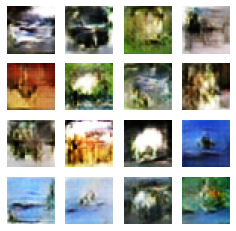

Time for training : 3205 sec


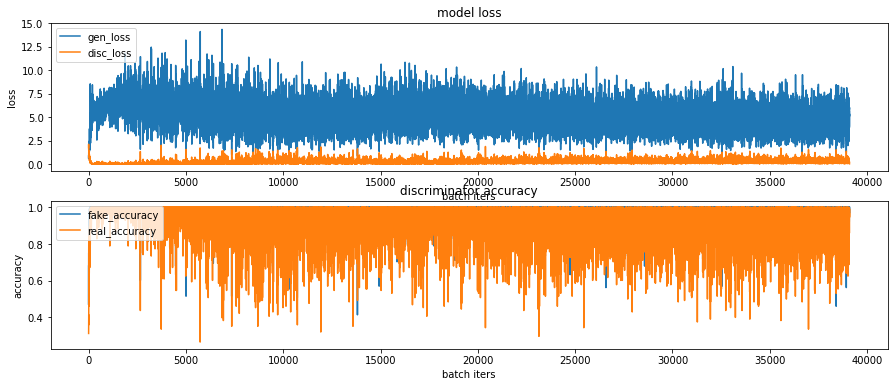

CPU times: user 54min 16s, sys: 2min 46s, total: 57min 3s
Wall time: 53min 28s


In [59]:
%%time
train(train_dataset, EPOCHS, save_every)

- discriminator 의 loss 가 줄어들고 있으며, generator loss 또한 천천히 줄어드는 모습을 보여주고 있습니다.
- real accuracy 와 fake accuracy 는 큰 변동폭을 보여주고 있습니다.
- real accuracy 는 0.4 이하로도 나와주고 있으며, fake accuracy 또한 0.5 로 도출되는 모습이 보입니다.
- 다만, 대체적으로 학습이 불안정하고, discriminator 가 generator 보다 먼저 학습되어 과적합이 발생했을 가능성이 보입니다.

# Source Code 1.1) 학습과정 시각화

In [23]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/dcgan_cifar10.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'
                          .format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

-rw-r--r-- 1 root root 1055516 Feb  8 06:21 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


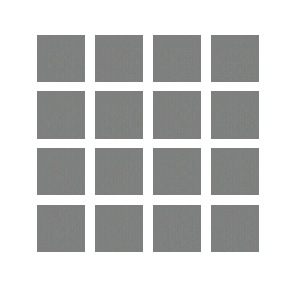

In [25]:
display.Image(anim_file)

# Source Code 1.1) 추가 학습

In [26]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

- 앞선 모델의 학습이 부족하다고 생각되어 추가학습을 진행시켜주겠습니다.
- 마지막으로 학습된 모델을 checkpoint 에서 불러옵니다.

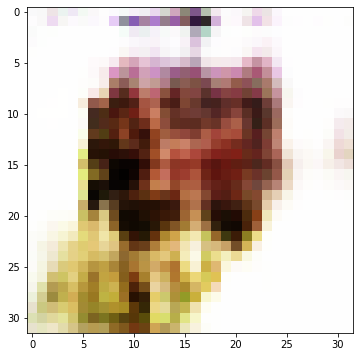

In [40]:
# Test
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5
np_generated = np_generated.astype(int)

plt.imshow(np_generated[0])
plt.show()

- 불러온 모델이 정상적으로 학습이 진행되었는지 확인합니다.

In [41]:
save_every = 5
EPOCHS = 100

In [42]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 100 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+101, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+101, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+101, int(time.time() - epoch_start)))
                
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs+100, it, seed)
        print('Time for training : {} sec'.format(int(time.time() - start)))
        
        draw_train_history(history, epoch+100)

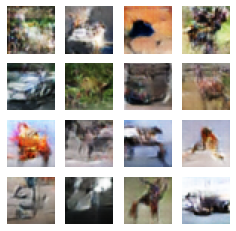

Time for training : 3136 sec


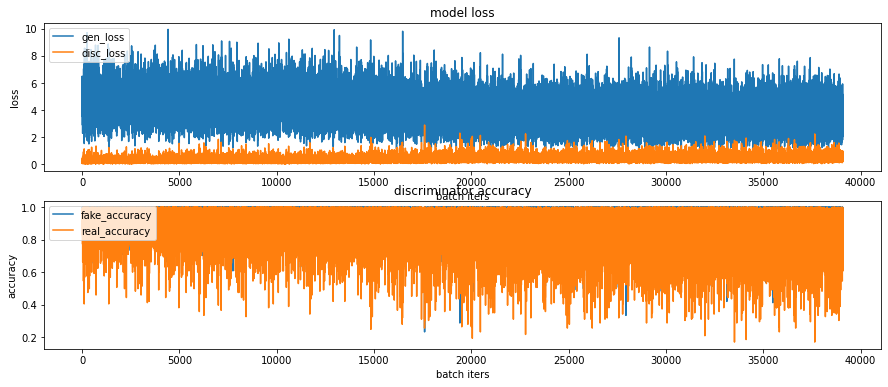

CPU times: user 53min 7s, sys: 2min 48s, total: 55min 56s
Wall time: 52min 19s


In [43]:
%%time
train(train_dataset, EPOCHS, save_every)

- 100 회의 EPOCH 를 추가로 학습하였다.
- gen_loss 는 이전과 비교하여 조금 감소하였지만, 효율적인 학습이 이루어지지는 않았다고 판단했다.
- real_accuracy 는 이전과 비교하여 0.5 이하로도 떨어지는 모습을 보여주고 있다.
- EPOCH 가 진행될수록 학습이 더욱 불안정해지는 모습이 보여진다.
- discriminator 의 loss 는 안정적으로 학습되는 반면, generator 의 loss 가 불안정하고 빠르게 수렴하지 못하고 있다.

# Source Code 1.1) 학습과정 시각화_2

In [44]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/dcgan_cifar10_2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'
                          .format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

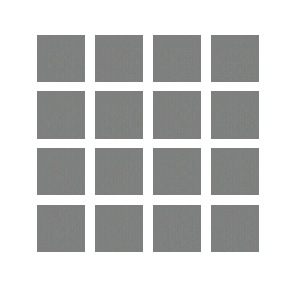

In [45]:
display.Image(anim_file)

- gif 이미지를 확인해보면 추가학습을 진행하지 않았을 때와 진행하였을 때의 이미지 선명도 차이가 크게 발생하는 것을 알 수 있다.

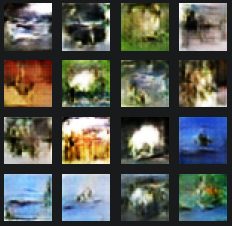

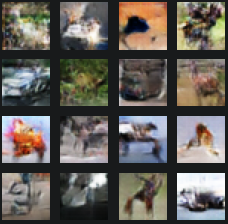

- 위는 EPOCH 100 회 학습을 진행하였을 때의 결과물이고, 아래는 EPOCH 100 회를 추가로 학습한 모델의 결과물이다. 선명도와 자연스러움에서 차이가 나는 것을 확인할 수 있다.

# Source Code 1.2)

- 1.2) 에서는 Batch size, momentum 을 변경하고, discriminator 의 층을 얕게 설계하여 학습을 진행시켰습니다.

### Load Data

In [85]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

print(f'train_x.shape : {train_x.shape}')
print(f'test_x.shape : {test_x.shape}')

train_x.shape : (50000, 32, 32, 3)
test_x.shape : (10000, 32, 32, 3)


### Data Preprocessing

In [86]:
train_x = (train_x - 127.5) / 127.5
test_x = (test_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [87]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Generator Modeling

In [88]:
def make_generator_model(momentum=0.9, alpha=0.2):

    model = tf.keras.Sequential()

    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Reshape((4, 4, 512)))

    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [89]:
generator = make_generator_model()

generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8192)              819200    
_________________________________________________________________
batch_normalization_11 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_12 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 8, 8, 256)        

### Discriminator Modeling

In [90]:
def make_discriminator_model(momentum=0.9, alpha=0.2):

    model = tf.keras.Sequential()

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())

    model.add(layers.Dense(1))

    return model

In [91]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 16, 16, 128)       9728      
_________________________________________________________________
batch_normalization_14 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
batch_normalization_15 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 8, 8, 256)        

### Generator Loss

In [92]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Discriminator Loss

In [93]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Discriminator Accuracy

In [94]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### Optimizer

In [95]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

In [96]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### Train Step Modeling

In [97]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output,
                                                              fake_output)
        
    grad_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(grad_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

### Util Function

In [98]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        predictions[i]
        plt.imshow((predictions[i] + 1) / 2.0)
        plt.axis('off')
        
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10_2/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                .format(os.getenv('HOME'), epoch, it))
    
    plt.show()

In [99]:
rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch):
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
    
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10_2/training_history/train_history_{:04d}.png'
                .format(os.getenv('HOME'), epoch))
    
    plt.show()

In [100]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_2/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Training

In [101]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time() - epoch_start)))
                
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time() - start)))
        
        draw_train_history(history, epoch)

In [102]:
save_every = 5
EPOCHS = 100

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

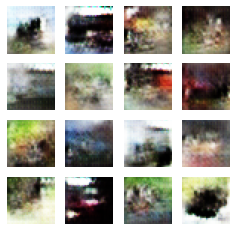

Time for training : 4206 sec


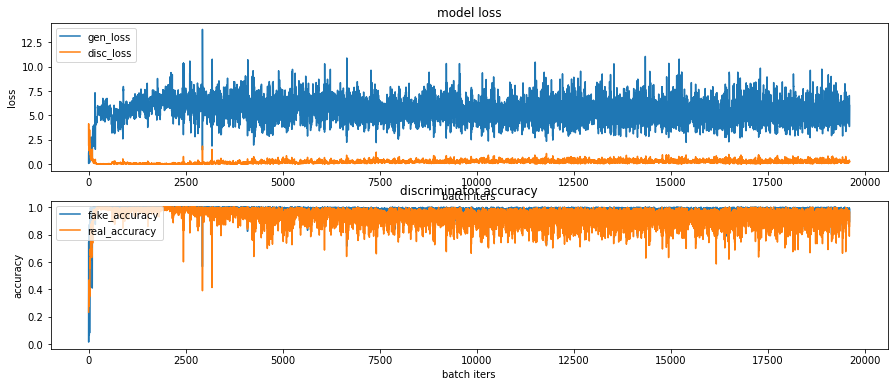

CPU times: user 1h 10min 43s, sys: 2min 41s, total: 1h 13min 25s
Wall time: 1h 10min 8s


In [103]:
%%time
train(train_dataset, EPOCHS, save_every)

- 학습 그래프가 1.1) 과 비교하여 안정적이다.
- batch size 를 줄인 것이 도움이 된 것으로 보인다.
- 하지만 여전히, gen_loss 는 학습 속도가 현저히 느리다.

# Source Code 1.2) 추가 학습

- 앞선 모델의 학습이 부족하다고 판단되어 추가 학습을 진행시켜주겠습니다.

In [104]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_2/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

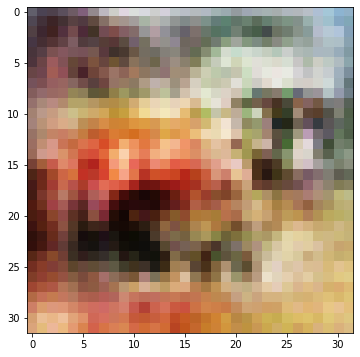

In [105]:
# Test
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5
np_generated = np_generated.astype(int)

plt.imshow(np_generated[0])
plt.show()

In [106]:
save_every = 5
EPOCHS = 100

In [108]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+101, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+101, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+101, int(time.time() - epoch_start)))
                
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs+100, it, seed)
        print('Time for training : {} sec'.format(int(time.time() - start)))
        
        draw_train_history(history, epoch+100)

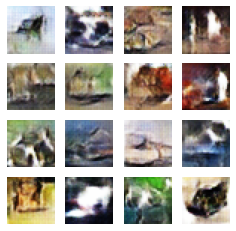

Time for training : 4214 sec


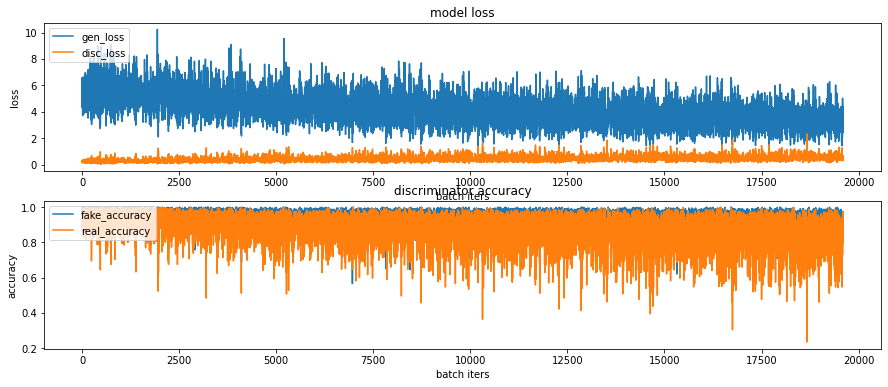

CPU times: user 1h 10min 50s, sys: 2min 42s, total: 1h 13min 33s
Wall time: 1h 10min 16s


In [109]:
%%time
train(train_dataset, EPOCHS, save_every)

- gen_loss 가 안정적으로 감소하고 있습니다.
- accuracy 의 경우에도 0.5 로 학습되고 있는 모습을 확인할 수 있습니다.
- Source Code 1.2) 는 1.1 과 비교해 Batch size, momentum, discriminator 의 구성이 달라졌습니다.
- Batch size 는 256 으로 안정적인 학습을 위해 높여주었습니다.
- momentum 은 일반적으로 사용하는 0.9 로 높여주었습니다.
- generator 와 discriminator 의 학습 진행 속도를 어느정도 맞춰주기 위해 discriminator 의 층을 제거하여 비교적 얕게 구성해주었습니다.

# Source Code 1.2) 학습과정 시각화

In [110]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_2/dcgan_cifar10_2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10_2/generated_samples/sample*.png'
                          .format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

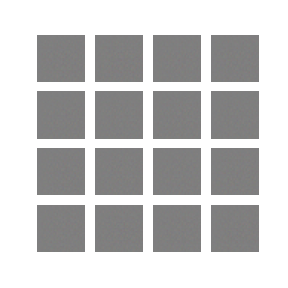

In [111]:
display.Image(anim_file)

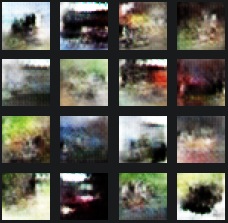

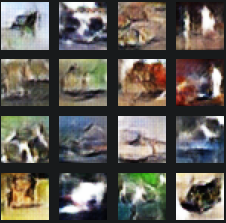

- Source Code 1.2) 에서 EPOCH 100 회 학습한 결과와 100 회의 추가학습을 수행한 결과입니다.
- 추가 학습을 진행한 결과물이 훨씬 자연스러워보이므로 학습이 정상적으로 진행되었다고 판단하였습니다.
- 또한, 앞선 추가학습에서 gen_loss 가 안정적으로 학습하는 모습을 보여주었으므로 추가적으로 학습을 더 시켜주도록 하겠습니다.

# Source Code 1.2) 추가학습_2